<strong>Prendre le fichier geoJSON et en faire un dataframe avec une colonne correspondant au nom du centre de réanimation, une colonne latitude et une colonne longitude et chaque ligne est un point

In [1]:
import geopandas as gpd

gdf = gpd.read_file("../data/reanimation.geojson")
gdf['latitude'] = gdf['geometry'].y
gdf['longitude'] = gdf['geometry'].x
gdf['name'] = gdf['name']

df = gdf[["name","latitude","longitude"]]

df.to_csv("points.csv",index=False, encoding="utf-8")

<strong>Algorithme des K-means avec modification du CSV points.csv en ajoutant une colonne avec le numéro du cluster associé au point</strong>

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Générer des données aléatoires
X = np.array(df[["latitude", "longitude"]])

# Initialiser l'algorithme des K-means
best_k = 1
best_preds = None
best_centroids = None
best_score = -1
for k in range(2, 11):
    # Exécuter l'algorithme sur les données avec k clusters
    kmeans = KMeans(n_clusters=k, n_init=10).fit(X)

    # Prédire le cluster associé à chaque point
    preds = kmeans.predict(X)

    # Obtenir les centroïdes des clusters
    centroids = kmeans.cluster_centers_

    # Calculer le coefficient de silhouette pour chaque itération
    score = silhouette_score(X, preds)
    print("For k = {}, silhouette score is {}".format(k, score))

    if score > best_score:
        best_k = k
        best_preds = preds
        best_centroids = centroids
        best_score = score

print("\nBest silhouette score is {} with {} clusters".format(best_score, best_k))

# Afficher les labels prédits pour chaque point
df["cluster"] = best_preds
df.to_csv("points.csv", index=False, encoding="utf-8")


For k = 2, silhouette score is 0.4705550423394552
For k = 3, silhouette score is 0.5131730940370476
For k = 4, silhouette score is 0.5144982424533288
For k = 5, silhouette score is 0.5414770635373216
For k = 6, silhouette score is 0.5443784453095634
For k = 7, silhouette score is 0.48956130993427543
For k = 8, silhouette score is 0.4894384612297683
For k = 9, silhouette score is 0.5118145382830461
For k = 10, silhouette score is 0.5248877049384509

Best silhouette score is 0.5443784453095634 with 6 clusters


C:\Users\paulp\AppData\Local\Temp\ipykernel_11300\2951680727.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster"] = best_preds


<strong>Affichage des clusters et de leur centroïde avec Matplotlib

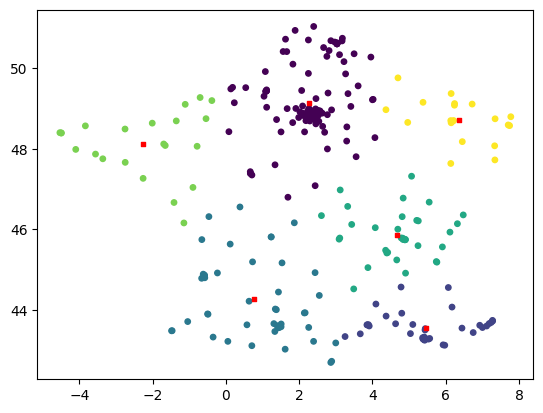

In [3]:
import matplotlib.pyplot as plt

# Affichage des clusters
plt.scatter(X[:,1], X[:,0], s = 15, c = best_preds)
plt.scatter(best_centroids[:, 1], best_centroids[:, 0], s = 10, c = 'r', marker='s')
plt.show()

<strong>Créer un dataframe avec les centroïdes et leurs clusters associés</strong>

In [4]:
import pandas as pd
centroids = best_centroids.tolist()
for i in range(len(centroids)):
    centroids[i].append(i)
    centroids[i].insert(0, "Centroïde_"+str(i))
print(centroids)

df_centroids = pd.DataFrame(centroids, columns=["name","latitude","longitude","cluster"])
df_centroids.to_csv("centroids.csv", index=False, encoding="utf-8")


[['Centroïde_0', 49.13973150076923, 2.268615294615384, 0], ['Centroïde_1', 43.55339379756097, 5.465806873170732, 1], ['Centroïde_2', 44.26092385957447, 0.7799167702127661, 2], ['Centroïde_3', 45.870407557142855, 4.683624474285714, 3], ['Centroïde_4', 48.117633022727276, -2.2627067999999997, 4], ['Centroïde_5', 48.71504104, 6.366201865, 5]]


<strong>Créer un fichier geoJSON à partir du csv créer avec les points (Inutile)</strong>

In [5]:
# !pip3 install pandas_geojson
from pandas_geojson import to_geojson
from pandas_geojson import write_geojson

geo_json = to_geojson(df=df, lat='latitude', lon='longitude',
                 properties=['name','cluster'])
write_geojson(geo_json, filename='points.geojson', indent=4)
# pts_geojson = gpd.read_file("points.geojson")  # permet d'afficher sans problème d'encodage le fichier geoJSON


<strong>Ajouter les centroïdes dans le fichier geojson points.geojson et créer un dataframe avec points et centroïdes</strong>

In [6]:
df_all = df.append(df_centroids)

df_all.to_csv("points+centroides.csv", index=False, encoding="utf-8")

geo_json = to_geojson(df=df_all, lat='latitude', lon='longitude',
                 properties=['name','cluster'])
write_geojson(geo_json, filename='points+centroides.geojson', indent=4)

C:\Users\paulp\AppData\Local\Temp\ipykernel_11300\167258032.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df.append(df_centroids)


<strong>Récupérer le code de Augustin et le copier-coller ici car l'importation en marche pas</strong>

In [7]:
from pprint import pprint
# !pip3 install geopy
from geopy.distance import distance
from scipy.spatial.distance import pdist, squareform
from geopy.distance import great_circle
import numpy as np
# !pip3 install fiona
# !pip3 install gdal
# !pip3 install proj
import geopandas as gpd

df = pd.read_csv('../Clustering/points+centroides.csv')
# Sélection des colonnes à utiliser pour calculer les distances
cols = ['name', 'latitude', 'longitude', 'cluster']
df_sub = df[cols]

# Extraction des noms de points
points = df_sub['name']

# Calcul de la matrice de distances
coords = df_sub[['latitude', 'longitude']].values
dist_matrix = squareform(pdist(coords, (lambda u,v: great_circle(u,v).km)))

# Création d'un dataframe à partir de la matrice de distances
dist_df = pd.DataFrame(dist_matrix, index=points, columns=points)

# Ajout des colonnes 'latitude', 'longitude' et 'cluster' à la matrice de distances
dist_df = df_sub[['name', 'latitude', 'longitude', 'cluster']].merge(dist_df, left_on='name', right_index=True)

# Affichage et exportation en CSV de la matrice de distances
dist_df.set_index('name', inplace=True)

# on va créer les tournées pour chaque cluster
centroide = pd.read_csv("centroids.csv").name # on crée un dataframe qui ne contient que les  centroides car ce sont els points de départ de chaque tournée

clusters = dist_df.cluster.unique()
def dictPoints(clusters = clusters):
    """crée un dictionnaire. chaque entrée est le numéro de cluster. chque entrée contient une liste des points qui sont dans le cluster.

    Returns:
        dict: clef = id cluster. entrée : liste des points de ce cluster
    """
    dicTournee = {}
    # Création d'une liste vide pour chaque cluster
    for elt in clusters:
        dicTournee[elt] = []
    
    #on ajoute chaque point dans son entrée de dictionnaire
    for idx, row in df.iterrows():
        cluster = row['cluster']
        name = row['name']
        if cluster in dicTournee:
            if name[0:9] != 'Centroïde':
                dicTournee[cluster].append(name)
    return dicTournee
    

def distance(point1, point2,df=dist_df):
    """
    point1 et point2 sont des str.\n
    renvoie la distance dans la matrice de distance entre le point1 et le point2.
    """
    distance = df[point1][point2]
    distance = int(round(float(distance)))
    return distance





def plus_proche_voisin(point1, points_restants):
    """
    Calcule le point le plus proche de point1, en augmentant la valeur minimale de la distance 
    tant que le point le plus proche et point1 n'ont pas le même cluster

    Args:
        point1 (str): Nom du point pour lequel on cherche le plus proche voisin
        df (DataFrame): DataFrame des distances
        points_restants (list): Liste des points restants à parcourir

    Returns:
        str: Nom du point le plus proche appartenant au même cluster que point1
    """
    res = None
    dist=9999 # on met une grande distance qu'on cherche à minimiser au fur et à mesure
    for elt in points_restants:
        if dist > distance(elt,point1):
            dist = distance(elt,point1)
            res = elt
    return res



def IdToCentroide(id, df=dist_df):
    """fonction qui prends un entier  le numéro de cluster et renvoie le centroide en str qui correspond

    Args:
        id (int): id du cluster correspondant au centroide
    
    Return (str) : le centoride correspondant au cluster
    """
    for index in df.index:
        if index == "Centroïde_"+str(id): # cherche l'index correspondant à l'id demandé
            return index


def tournees(idCentroide, seuil = 200, df = dist_df):
    """calcule les tournées pour le cluster donnés et les points qu'il doit parcourir.


    Args:
        centroide (int): le centroide correspondant au cluster et aux points.
        seuil (int) : nombre de km max que la gars peut faire en une tournée. 

    Returns : res (lis) : une liste de liste qui contient les tournées pour ce cluster
    """
    nb=0
    res=[]
    nameCentroide = IdToCentroide(idCentroide)
    liste_points = dictPoints(clusters = clusters)[idCentroide] # on récupère les ppoints que doit parcourir depuis ce centroide.
    liste_points_restants = liste_points.copy()
    while len(liste_points_restants) > 0 :
        tournee = [nameCentroide] # on initialise la tournée avec comme point de départ le centroide.
        distance_tournee = 0

        #on va chercher le point le plus proche
        proche = plus_proche_voisin(tournee[-1], points_restants = liste_points_restants) #on cherche le point le plus proche du avant dernier point de la tournée
        tournee.append(proche)
        liste_points_restants.remove(proche)
        distance_tournee += distance(point1=tournee[0], point2=tournee[-1])
        # on va rajouter le point plus proche seulement si on ne dépasse pas le seuil de km par jour en comptant le retour au point d'arrivée.
        if len(liste_points_restants) == 0:
            tournee.append(nameCentroide)
            res.append(tournee)
        while len(liste_points_restants) > 0:
            proche = plus_proche_voisin(point1= tournee[-1],  points_restants = liste_points_restants) #on cherche le point le plus proche du avant dernier point de la tournée
            if (distance_tournee + distance(tournee[-1], proche)+distance(proche, nameCentroide)) < seuil:
                #on va ajouter le proche en avant dernière position de la tournée.
                distance_tournee+= distance(point1 = tournee[-1], point2 = proche) # ajoute à la distance de la tournée le nombre de km supplémentaire
                tournee.append(proche) #ajouter le point

                liste_points_restants.remove(proche) #supprimer le point qu'on vient d'ajouter de la liste des villes restantes. 
                if len(liste_points_restants) == 0:
                    tournee.append(nameCentroide)
                    res.append(tournee)

            else :
                tournee.append(nameCentroide)
                res.append(tournee)
                break
        
    return res


def algoTSP():
    """calculer les tournées cluster par cluster
    """
    # if __name__ == '__main__':
    dict = {}
    for cluster in clusters:
        var = tournees(cluster, seuil = 800, df = dist_df)
        dict[cluster] = var
    return dict


dict_tournees = algoTSP()
dict_tournees = dict(sorted(dict_tournees.items()))
print(dict_tournees)
for entree in dict_tournees.values():
    for sous_liste in entree:
        print(sous_liste)




{0: [['Centroïde_0', 'Hôpital Simone Veil', "Centre hospitalier d'Argenteuil", 'Hôpital Louis Mourier', 'American Hospital of Paris', 'Hopital Beaujon', 'Hôpital Bichat-Claude Bernard', 'Hôpital Lariboisière', 'Hôpital Saint-Louis', 'Fondation ophtalmologique Adolphe de Rothschild', 'Hôpital Tenon', 'Hôpital Croix Saint-Simon', 'Hôpital Armand-Trousseau', "Hôpital d'Instruction des Armées Bégin", 'Hôpital Saint-Antoine', 'Hôpital Pitié-Salpêtrière', 'Clinique Geoffroy Saint-Hilaire', 'Hôpital Cochin', 'GHU Paris Psychiatrie & neurosciences - site Sainte-Anne', 'Institut Mutualiste Montsouris', 'Hôpital Bicêtre', 'Hôpital Paul Brousse', 'Institut Gustave Roussy', "Hôpital Privé d'Antony", 'Hôpital privé Jacques Cartier', 'Centre hospitalier de Longjumeau', "Centre hospitalier d'Orsay", 'Centre Chirurgical Marie Lannelongue', 'Hôpital Antoine Béclère', "Hôpital d'Instruction des Armées Percy", 'Hôpital Européen Georges Pompidou', 'Hôpital Ambroise Paré', "Clinique du Val d'Or", 'Hôpital 

<strong>Essayer de créer un fichier geoJSON avec une liste de liste de test correspondant à plusieurs tournées d'un cluster</strong>

In [30]:
import geojson

#faire un copier coller de l'algo ou l'importer dans le même dossier
def create_tuple(row):
        return (row['longitude'], row['latitude'])  #je met d'abord longitude puis latitude car le fichier geojson prend des coordonnées avec ce format [longitude, latitude]

#Ce bloc va permettre de créer un dictionnaire qui aura la forme de ce qu'il y a en sortie de l'algo TSP
# dict_tournees = {}
# for i in range(0,best_k):
#     # Prend la liste des noms (identifiants) et divise cette liste en plusieurs parties pour ressembler à ce qu'il y aura en sortie de l'algo TSP
#     ex_list = df.loc[df['cluster'] == i, 'name'].values
#     ex_list = np.array_split(ex_list, 4)

#     # Change le format de numpy à une liste normale
#     new_list = []
#     for l in ex_list:
#         l = l.tolist()
#         new_list.append(l)

#     #Je crée un dictionnaire qui ressemblera à ce qu'il y aura en sortie de l'algorithme TSP
#     dict_tournees[i] = new_list

# print(dict_tournees)
    
# --------- CODE POUR CREER LE FICHIER GEOJSON A PARTIR DU DICTIONNAIRE DU TSP ---------
features = []

for k in range(0, best_k):
    
    # Créer une liste finale où il y aura à l'intérieur l'ensemble des tuples
    l_finale = []
    tournees = {}
    i = 0
    for l in dict_tournees[k]:  #créer la liste de tuples des pts de geolocaliation
        result = df_all.loc[df_all['name'].isin(l)]
        # Définir la colonne 'nom' comme index
        result = result.set_index('name')

        # Réorganiser le DataFrame en utilisant l'ordre des noms
        result = result.reindex(l)

        # Remettre la colonne 'nom' dans le DataFrame
        result = result.reset_index()

        tuples = result.apply(create_tuple, axis=1).tolist()
        tournees[i] = tuples
        i += 1

    for key,value in tournees.items():
        points = value
        line = geojson.LineString(points)

        feature = geojson.Feature(geometry=line)
        feature["properties"] = {"cluster":k, "num_tournee": key}
        features.append(feature)
        # print(feature)


# Créer une feature collection à partir de la liste de features
feature_collection = geojson.FeatureCollection(features)

# Écrire la feature collection dans un fichier geoJSON
with open('test.geojson', 'w') as f:
    geojson.dump(feature_collection, f, indent=4)

Test algorithme EM (gaussianmixture)

For k = 2, silhouette score is 0.46345832590815367
For k = 3, silhouette score is 0.4867032410748757
For k = 4, silhouette score is 0.49465408987567594
For k = 5, silhouette score is 0.5275465172912843
For k = 6, silhouette score is 0.378077207520854
For k = 7, silhouette score is 0.4733167371237335
For k = 8, silhouette score is 0.3046135292998779
For k = 9, silhouette score is 0.32613785896592073
For k = 10, silhouette score is 0.4112131993459257

Best silhouette score is 0.5275465172912843 with 5 clusters
Moyennes des distributions:
[[48.07845049 -3.81130994]
 [48.84775221  2.34653857]
 [43.4766918   5.51396259]
 [43.88574413  0.82171828]
 [48.68402019  6.58618598]
 [45.67899698  5.04299828]
 [47.22493724 -0.87953082]
 [50.5891882   2.9261368 ]
 [49.24869414  1.85407749]
 [46.94009602  2.36415999]]
Covariances des distributions:
[[[ 1.39451455e-01 -2.25799306e-01]
  [-2.25799306e-01  4.84234155e-01]]

 [[ 5.22468223e-03  4.29898706e-04]
  [ 4.29898706e-04  1.73256634e-02]]

 [[ 4.85

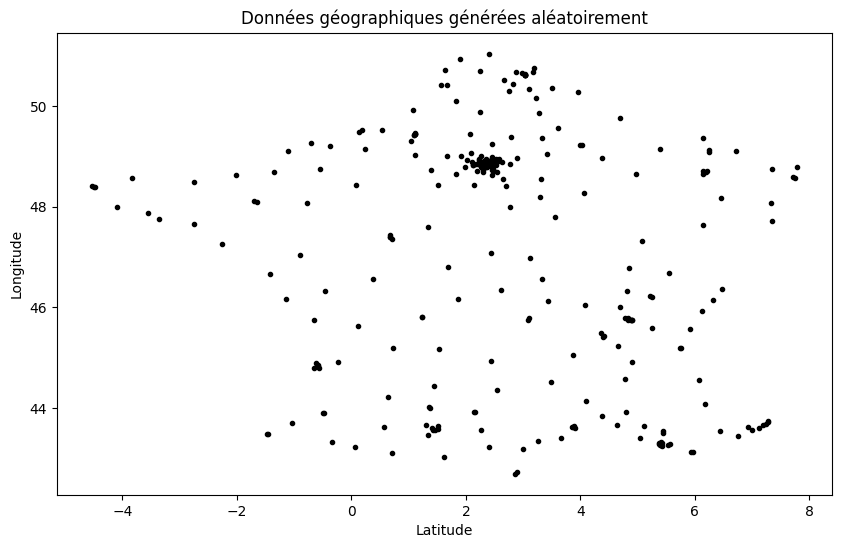

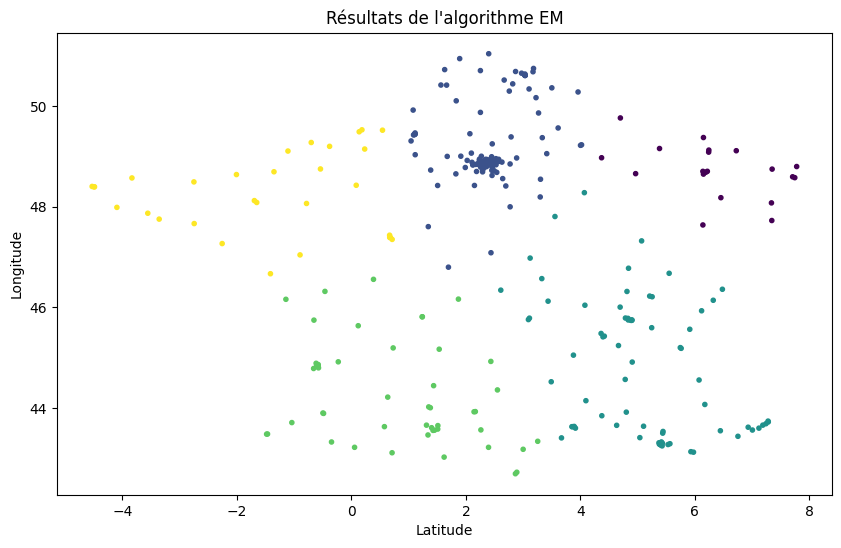

In [9]:
# Importer les bibliothèques nécessaires
from sklearn.mixture import GaussianMixture
import pandas as pd
from sklearn.metrics import silhouette_score


X = pd.read_csv("points.csv", encoding="utf-8")[["latitude", "longitude"]].values
# print(X)

# Afficher les données générées sur un graphique
plt.figure(figsize=(10,6)) # créer une figure avec une taille donnée
plt.scatter(X[:,1], X[:,0], c='black', marker='.') # tracer les points avec une couleur et un marqueur donnés
plt.xlabel('Latitude') # ajouter un label pour l'axe des x
plt.ylabel('Longitude') # ajouter un label pour l'axe des y
plt.title('Données géographiques générées aléatoirement') # ajouter un titre au graphique

# Appliquer l'algorithme EM avec le nombre de clusters
best_k = 1
best_preds = None
best_score = -1
for k in range(2, 11):
    # Exécuter l'algorithme sur les données avec k clusters
    gm = GaussianMixture(n_components=k).fit(X)

    # Prédire le cluster associé à chaque point
    preds = gm.predict(X)

    # Calculer le coefficient de silhouette pour chaque itération
    score = silhouette_score(X, preds)
    print("For k = {}, silhouette score is {}".format(k, score))

    if score > best_score:
        best_k = k
        best_preds = preds
        best_score = score

print("\nBest silhouette score is {} with {} clusters".format(best_score, best_k))

# Afficher les résultats de l'algorithme EM sur un autre graphique
plt.figure(figsize=(10,6)) # créer une autre figure avec une taille donnée
plt.scatter(X[:,1], X[:,0], c=best_preds, marker='.') # tracer les points avec une couleur correspondant au cluster prédit et un marqueur donné
plt.xlabel('Latitude') # ajouter un label pour l'axe des x
plt.ylabel('Longitude') # ajouter un label pour l'axe des y
plt.title('Résultats de l\'algorithme EM') # ajouter un titre au graphique

# Afficher les paramètres des distributions estimés par l'algorithme EM 
print('Moyennes des distributions:')
print(gm.means_)
print('Covariances des distributions:')
print(gm.covariances_)
